*** AIT 690 Smart Cities and Urban Computing ***

*** Final Project By Japneet S. Kohli ***

This file contains the code for the 2nd approach using Gaussian Mixture Models (GMM).

The code is exeuted in the following order:

1.  Import required libraries and packages
2.  Mount Google Drive. Google Colab was used as the platform to run this code.
3.  Load NY Crime Complaint Data.

*** Data Cleaning ***

4.  Drop unnecessary columns from dataset and rename columns.
5.  Convert categorical column "Law Code" into dummies for each category and add to dataset. 
6.  Merge complain date and time columns into one datetime column and assign it as index. In this step, records outside 2019 year are assigned "None" value so they will be removed in the next step.
7.  Remove non-date values from the dataframe. This eliminates all bad dates and dates outside 2019.

*** Data Exploration ***

8.  Analyze the Law Code Categories for 2019 for annual frequency of crime.
9.  Analyze the Law Code Categories for 2019 for monthly frequency of crime.
10. Analyze the Law Code Categories for 2019 for day-wise frequency of crime.
11. Analyze the Law Code Categories for 2019 for hour-wise frequency of crime.
12. Create subset of data with only 4 types of categories, namely i. sex crimes; ii. murder and non-negligent manslaughter crimes; iii. robbery crimes; iv. dangerous drugs crimes.
13. Add columns for above 4 categories using dummy values.
14. Analyze all 4 categories based on hour-of-day frequencies to notice interesting patterns.
15. Analyze drugs related crime data to find proportion of marijuana and sale related crimes respectively.
16. Plot the types of crimes based on Offense Descriptions and annual frequency to visualize commonness of various types of crimes.
17. Create dataframes containing data for the interesting patterns observed thus far.

*** Implementing Gaussian Mixture Models ***

18. Define function to extract latitude/longitude coordinate data from interesting pattern dataframes.
19. Define function to analyze coord data extracted above using GMMs iterated over varying number of components and plot aic/bic curve for all models belonging to 1 dataframe. 
20. Define function to draw ellipse with given position and covariance.
21. Define function to plot a GMM with clusters shown within ellipses.
22. Run the above functions over the interesting pattern dataframes and select best models based on evaluation of aic/bic.
23. Export the interesting pattern dataframes' coordinates and cluster prediction values for best models selected to visualize them in ArcMap.

*** End ***


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import mixture
from matplotlib.patches import Ellipse


To use Google Colab, a Google Drive must be mounted. This is done in below code.

In [3]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Load data
complaint_data = pd.read_csv("NYPD_Complaint_Map__Year_to_Date_.csv")


In [5]:
complaint_data.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Lat_Lon,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
0,314773184,48,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,POINT (-73.88168118799997 40.838026269000075),1016990,244612,40.838026,-73.881681
1,289837961,25,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,POINT (-73.94565697199994 40.800334261000046),999296,230862,40.800334,-73.945657
2,535744284,77,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,NaN,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,POINT (-73.93937555099996 40.66983179600004),1001068,183317,40.669832,-73.939376
3,895678119,52,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,NaN,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,POINT (-73.90801364899994 40.87367103500002),1009690,257590,40.873671,-73.908014
4,299841674,18,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,NaN,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,POINT (-73.99452906599998 40.76093528000007),985766,216503,40.760935,-73.994529


In [6]:
# Drop columns from crime complaint dataset and rename columns

df = complaint_data.copy()
#df = df.loc[1:10000]
df.drop(['JURIS_DESC', 'ADDR_PCT_CD', 'PARKS_NM', 'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 
              'Lat_Lon', 'LOC_OF_OCCUR_DESC', 
              'KY_CD', 'PD_CD', 'PD_CD'], axis=1, inplace=True) 
df.columns
df.columns = ['CMPLT_NUM', 'BORO_NM', 'CMPLNT_FR_DT','CMPLNT_FR_TM', 'CMPLNT_TO_DT',
              'CMPLNT_TO_TM', 'CRM_STTUS', 'LAW_CODE', 'OFNS_DESC', 
              'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'LATITUDE', 'LONGITUDE']
df.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE
0,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681
1,289837961,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657
2,535744284,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,FELONY,FELONY ASSAULT,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376
3,895678119,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014
4,299841674,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529


In [7]:
# Merge date and time columns into one datetime column and assign it as the index. The complaint from date and time are used for this purpose.
# Also create columns for each category of law code (violations, felonies, and midemeanors).

df2 = df.copy()
# define function to keep only 2019 data
def date_change(x):
    if x[2] > '2019':
        x = None
    elif x[2] < '2019':
        x = None
    else:
        aa= '/'.join(x)
        return (aa)

# get columns for law code
df2 = df2.join(df2['LAW_CODE'].str.get_dummies()) # law codes are violations, felonies and misdemeanors

# process complaint date and time columns 
df2.dropna(subset=['CMPLNT_FR_DT'], inplace=True) # drop empty dates
df2['CMPLNT_FR_DT'] = df2['CMPLNT_FR_DT'].str.split("/") # create a list for each value so year element can be examined
df2['CMPLNT_FR_DT'] = df2['CMPLNT_FR_DT'].apply(lambda x: date_change(x)) # examine date years

df2['Date_OCCRD'] = df2['CMPLNT_FR_DT'] +' '+df2['CMPLNT_FR_TM'] # create one column for both date and time columns combined
df2['Date_OCCRD'] = pd.to_datetime(df2['Date_OCCRD']) # convert to datetime format
df2['Date_OCCRD2'] = df2['Date_OCCRD']
df2.set_index('Date_OCCRD', inplace=True) # set above datetime column as index

df2.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,Date_OCCRD2
Date_OCCRD,,,,,,,,,,,,,,,,,,
2019-12-31 18:00:00,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,2019-12-31 18:00:00
2019-12-30 20:30:00,289837961,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657,0,1,0,2019-12-30 20:30:00
2019-12-24 16:55:00,535744284,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,FELONY,FELONY ASSAULT,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376,1,0,0,2019-12-24 16:55:00
2019-12-30 19:32:00,895678119,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014,0,1,0,2019-12-30 19:32:00
2019-12-30 15:30:00,299841674,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,MISDEMEANOR,PETIT LARCENY,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529,0,1,0,2019-12-30 15:30:00


In [8]:
df2['Date_OCCRD2'].min()

Timestamp('2019-01-01 00:00:00')

In [9]:
df2['Date_OCCRD2'].max()

Timestamp('2019-12-31 23:35:00')

In [10]:
df2.info()
print('Some datetime values are not dates. These should be removed from analysis')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461711 entries, 2019-12-31 18:00:00 to NaT
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CMPLT_NUM      461711 non-null  int64         
 1   BORO_NM        461385 non-null  object        
 2   CMPLNT_FR_DT   450976 non-null  object        
 3   CMPLNT_FR_TM   461711 non-null  object        
 4   CMPLNT_TO_DT   403712 non-null  object        
 5   CMPLNT_TO_TM   403950 non-null  object        
 6   CRM_STTUS      461711 non-null  object        
 7   LAW_CODE       461711 non-null  object        
 8   OFNS_DESC      461699 non-null  object        
 9   PD_DESC        461392 non-null  object        
 10  PREM_TYP_DESC  459841 non-null  object        
 11  RPT_DT         461711 non-null  object        
 12  LATITUDE       461711 non-null  float64       
 13  LONGITUDE      461711 non-null  float64       
 14  FELONY         461711 non-null  in

In [11]:
# Removing non date values from dataframe
df2["TMP"] = df2.index.values               # this works because the index is a DateTimeIndex
df2 = df2[df2.TMP.notnull()]                  # remove all NaT values
df2.drop(["TMP"], axis=1, inplace=True)     # delete TMP column

In [12]:
df2.info()
print('Rows with non date index values have been removed. This ensures all the data belongs to 2019 year only.')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 450976 entries, 2019-12-31 18:00:00 to 2019-01-04 05:15:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CMPLT_NUM      450976 non-null  int64         
 1   BORO_NM        450677 non-null  object        
 2   CMPLNT_FR_DT   450976 non-null  object        
 3   CMPLNT_FR_TM   450976 non-null  object        
 4   CMPLNT_TO_DT   394679 non-null  object        
 5   CMPLNT_TO_TM   394912 non-null  object        
 6   CRM_STTUS      450976 non-null  object        
 7   LAW_CODE       450976 non-null  object        
 8   OFNS_DESC      450968 non-null  object        
 9   PD_DESC        450684 non-null  object        
 10  PREM_TYP_DESC  449191 non-null  object        
 11  RPT_DT         450976 non-null  object        
 12  LATITUDE       450976 non-null  float64       
 13  LONGITUDE      450976 non-null  float64       
 14  FELONY         450

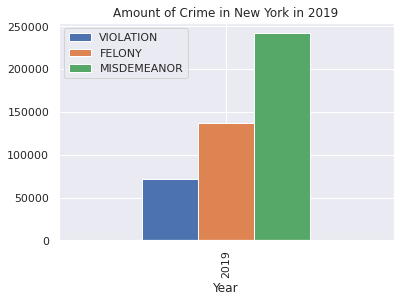

Misdemeanors are the most commonly reported type of crime, followed by felonies and violations respecively.


In [13]:
# Analysis of Crimes Grouped by Violations, Felonies and Misdemeanor in 2019 

dfYear = df2.copy()
dfYear.index = dfYear.index.year
vis0 = dfYear.groupby([dfYear.index.get_level_values(0)])[['VIOLATION','FELONY','MISDEMEANOR']].sum()
vis0.plot.bar()
plt.title('Amount of Crime in New York in 2019')
plt.xlabel('Year')
plt.show()
print ("Misdemeanors are the most commonly reported type of crime, followed by felonies and violations respecively.")

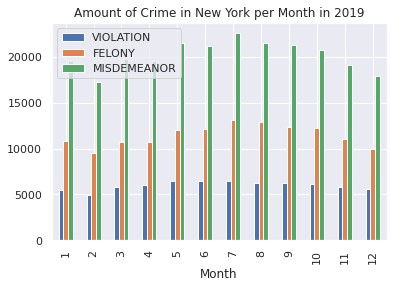

February has the least amount of overall crime by month. This may be because it has fewer days.
July has the highest of crime by month.


In [14]:
# Analysis of Crimes Grouped by Violations, Felonies and Misdemeanor per Month in 2019

dfMonth = df2.copy()
dfMonth.index = dfMonth.index.month
vis1 = dfMonth.groupby([dfMonth.index.get_level_values(0)])[['VIOLATION','FELONY','MISDEMEANOR']].sum()
vis1.plot.bar()
plt.title('Amount of Crime in New York per Month in 2019')
plt.legend(loc='upper left')
plt.xlabel('Month')
plt.show()
print ("February has the least amount of overall crime by month. This may be because it has fewer days.\nJuly has the highest of crime by month.")

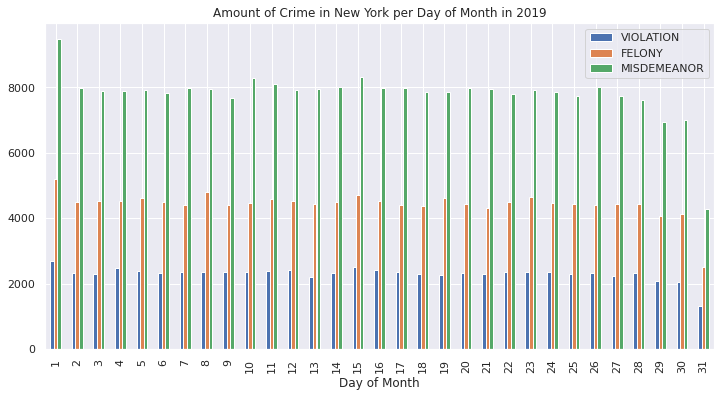

Highest crime happens on the 1st of the month, while the lowest happens on the 31st.
The low frequency of crimes on the 31st can be explained by the fact that only 7 months out of 12 have a 31st day.


In [15]:
# Analysis of Crimes Grouped by Violations, Felonies and Misdemeanor per Day of Month in 2019

dfDay = df2.copy()
dfDay.index = dfDay.index.day
vis2 = dfDay.groupby([dfDay.index.get_level_values(0)])[['VIOLATION','FELONY','MISDEMEANOR']].sum()
vis2.plot.bar(figsize=(12,6))
plt.title('Amount of Crime in New York per Day of Month in 2019')
plt.xlabel('Day of Month')
plt.show()
print ("Highest crime happens on the 1st of the month, while the lowest happens on the 31st.\nThe low frequency of crimes on the 31st can be explained by the fact that only 7 months out of 12 have a 31st day.")

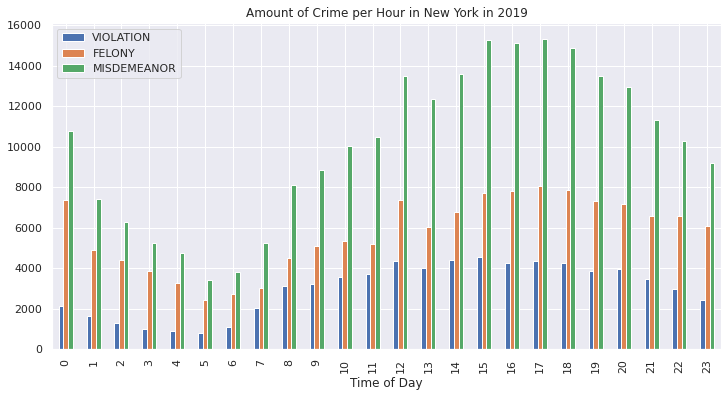

Highest crime happens during the day rather the night. At daytime, the highest concentration of crimes reported are between 3 pm and 6 pm.


In [16]:
# Analysis of Crimes Grouped by Violations, Felonies and Misdemeanor per Hour in 2019

dfHour = df2.copy()
dfHour.index = dfHour.index.hour  
vis3 = dfHour.groupby([dfHour.index.get_level_values(0)])[['VIOLATION','FELONY','MISDEMEANOR']].sum()
vis3.plot.bar(figsize=(12,6))
plt.title('Amount of Crime per Hour in New York in 2019')
plt.xlabel('Time of Day')
plt.show()
print ("Highest crime happens during the day rather the night. At daytime, the highest concentration of crimes reported are between 3 pm and 6 pm.")

In [17]:
vis0

,VIOLATION,FELONY,MISDEMEANOR
Date_OCCRD,,,
2019,71632,137569,241775


In [18]:
vis1

,VIOLATION,FELONY,MISDEMEANOR
Date_OCCRD,,,
1,5473,10830,19540
2,4990,9529,17251
3,5813,10756,19715
4,5991,10763,19493
5,6490,12011,21521
6,6420,12136,21152
7,6421,13057,22567
8,6290,12839,21521
9,6255,12355,21268


In [19]:
vis2

,VIOLATION,FELONY,MISDEMEANOR
Date_OCCRD,,,
1,2696,5188,9490
2,2344,4509,7974
3,2292,4529,7901
4,2484,4533,7881
5,2400,4628,7915
6,2322,4491,7833
7,2358,4422,7981
8,2357,4804,7960
9,2349,4417,7692


In [20]:
vis3

,VIOLATION,FELONY,MISDEMEANOR
Date_OCCRD,,,
0,2150,7376,10782
1,1632,4881,7426
2,1277,4387,6285
3,1013,3868,5257
4,926,3275,4769
5,808,2443,3413
6,1080,2746,3809
7,2035,3039,5271
8,3120,4528,8126


In [21]:
# Filter data frame to keep only records for offenses listed below.
dfOffense = df2.copy()
dfOffense = dfOffense.loc[dfOffense['OFNS_DESC'].isin(['SEX CRIMES', 'MURDER & NON-NEGL. MANSLAUGHTER', 'ROBBERY', 'DANGEROUS DRUGS'])]


In [22]:
dfOffense.info()
print('The size of this dataframe has been reduced to 33,199 rows.')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33199 entries, 2019-12-31 18:00:00 to 2019-01-06 02:10:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CMPLT_NUM      33199 non-null  int64         
 1   BORO_NM        32907 non-null  object        
 2   CMPLNT_FR_DT   33199 non-null  object        
 3   CMPLNT_FR_TM   33199 non-null  object        
 4   CMPLNT_TO_DT   28463 non-null  object        
 5   CMPLNT_TO_TM   28467 non-null  object        
 6   CRM_STTUS      33199 non-null  object        
 7   LAW_CODE       33199 non-null  object        
 8   OFNS_DESC      33199 non-null  object        
 9   PD_DESC        32907 non-null  object        
 10  PREM_TYP_DESC  32822 non-null  object        
 11  RPT_DT         33199 non-null  object        
 12  LATITUDE       33199 non-null  float64       
 13  LONGITUDE      33199 non-null  float64       
 14  FELONY         33199 non-null  int6

In [23]:
dfOffense.OFNS_DESC.unique()

array(['ROBBERY', 'SEX CRIMES', 'DANGEROUS DRUGS',
       'MURDER & NON-NEGL. MANSLAUGHTER'], dtype=object)

In [24]:
dfOffense.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,Date_OCCRD2
Date_OCCRD,,,,,,,,,,,,,,,,,,
2019-12-31 18:00:00,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,2019-12-31 18:00:00
2019-12-29 17:20:00,487138011,BRONX,12/29/2019,17:20:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/29/2019,40.830641,-73.874879,1,0,0,2019-12-29 17:20:00
2019-12-29 12:30:00,227601821,MANHATTAN,12/29/2019,12:30:00,12/29/2019,13:30:00,COMPLETED,MISDEMEANOR,SEX CRIMES,"SEXUAL ABUSE 3,2",STREET,12/29/2019,40.764818,-73.985190,0,1,0,2019-12-29 12:30:00
2019-12-23 14:41:00,260307851,MANHATTAN,12/23/2019,14:41:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,DELIVERY PERSON",STREET,12/23/2019,40.713476,-73.997303,1,0,0,2019-12-23 14:41:00
2019-12-22 00:15:00,175176016,BRONX,12/22/2019,00:15:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/22/2019,40.886651,-73.859425,1,0,0,2019-12-22 00:15:00


In [25]:
# create columns for categories of offense descriptions
dummies = dfOffense['OFNS_DESC'].str.get_dummies()
dfOffense = dfOffense.reset_index(drop=True).join(dummies.reset_index(drop=True)[['SEX CRIMES', 'MURDER & NON-NEGL. MANSLAUGHTER', 'ROBBERY', 'DANGEROUS DRUGS']])
dfOffense

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,Date_OCCRD2,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTER,ROBBERY,DANGEROUS DRUGS
0,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,2019-12-31 18:00:00,0,0,1,0
1,487138011,BRONX,12/29/2019,17:20:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/29/2019,40.830641,-73.874879,1,0,0,2019-12-29 17:20:00,0,0,1,0
2,227601821,MANHATTAN,12/29/2019,12:30:00,12/29/2019,13:30:00,COMPLETED,MISDEMEANOR,SEX CRIMES,"SEXUAL ABUSE 3,2",STREET,12/29/2019,40.764818,-73.985190,0,1,0,2019-12-29 12:30:00,1,0,0,0
3,260307851,MANHATTAN,12/23/2019,14:41:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,DELIVERY PERSON",STREET,12/23/2019,40.713476,-73.997303,1,0,0,2019-12-23 14:41:00,0,0,1,0
4,175176016,BRONX,12/22/2019,00:15:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/22/2019,40.886651,-73.859425,1,0,0,2019-12-22 00:15:00,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33194,523222593,BRONX,01/04/2019,16:18:00,01/04/2019,16:23:00,COMPLETED,MISDEMEANOR,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE, POSSESSI",STREET,01/04/2019,40.848583,-73.902677,0,1,0,2019-01-04 16:18:00,0,0,0,1
33195,384767882,MANHATTAN,01/01/2019,20:40:00,01/01/2019,20:50:00,COMPLETED,MISDEMEANOR,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE, POSSESSI",TRANSIT - NYC SUBWAY,01/01/2019,40.750999,-73.990625,0,1,0,2019-01-01 20:40:00,0,0,0,1
33196,510006616,QUEENS,01/01/2019,04:20:00,01/01/2019,06:00:00,COMPLETED,FELONY,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,POSSESS.",HIGHWAY/PARKWAY,01/01/2019,40.737766,-73.935922,1,0,0,2019-01-01 04:20:00,0,0,0,1
33197,827973866,BRONX,01/04/2019,14:08:00,01/04/2019,14:20:00,COMPLETED,FELONY,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",RESIDENCE - APT. HOUSE,01/04/2019,40.856183,-73.903147,1,0,0,2019-01-04 14:08:00,0,0,0,1


In [26]:
# reset index as datetime after merging columns above required setting index to default numbers

dfOffense['Date_OCCRD3'] = dfOffense['Date_OCCRD2']
dfOffense.set_index('Date_OCCRD2', inplace=True) # set above datetime column as index


In [27]:
dfOffense.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTER,ROBBERY,DANGEROUS DRUGS,Date_OCCRD3
Date_OCCRD2,,,,,,,,,,,,,,,,,,,,,,
2019-12-31 18:00:00,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,0,0,1,0,2019-12-31 18:00:00
2019-12-29 17:20:00,487138011,BRONX,12/29/2019,17:20:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/29/2019,40.830641,-73.874879,1,0,0,0,0,1,0,2019-12-29 17:20:00
2019-12-29 12:30:00,227601821,MANHATTAN,12/29/2019,12:30:00,12/29/2019,13:30:00,COMPLETED,MISDEMEANOR,SEX CRIMES,"SEXUAL ABUSE 3,2",STREET,12/29/2019,40.764818,-73.985190,0,1,0,1,0,0,0,2019-12-29 12:30:00
2019-12-23 14:41:00,260307851,MANHATTAN,12/23/2019,14:41:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,DELIVERY PERSON",STREET,12/23/2019,40.713476,-73.997303,1,0,0,0,0,1,0,2019-12-23 14:41:00
2019-12-22 00:15:00,175176016,BRONX,12/22/2019,00:15:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/22/2019,40.886651,-73.859425,1,0,0,0,0,1,0,2019-12-22 00:15:00


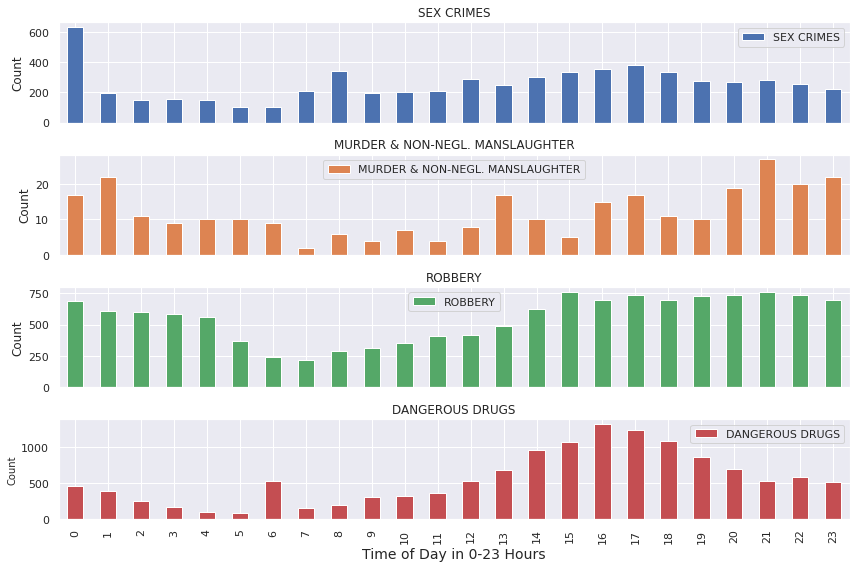

In [28]:
# Create visualization showing counts of various offense types

dfOffense.index = dfOffense.index.hour
vis4 = dfOffense.groupby([dfOffense.index.get_level_values(0)])[['SEX CRIMES', 'MURDER & NON-NEGL. MANSLAUGHTER', 'ROBBERY', 'DANGEROUS DRUGS']].sum()
axes = vis4.plot.bar(figsize=(12,8), subplots=True, sharex=True, sharey=False)
axes[0].set_ylabel('Count')
axes[1].set_ylabel('Count')
axes[2].set_ylabel('Count')
axes[3].set_ylabel('Count')
plt.xlabel('Time of Day in 0-23 Hours', fontsize=14)
plt.ylabel('Count', fontsize=10)
plt.tight_layout(h_pad=1)

plt.show()

In [29]:
vis4

,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTER,ROBBERY,DANGEROUS DRUGS
Date_OCCRD2,,,,
0,632,17,691,462
1,195,22,607,392
2,149,11,600,247
3,155,9,588,174
4,149,10,563,106
5,104,10,368,87
6,102,9,239,533
7,211,2,220,156
8,345,6,290,197


In [30]:
# Create dataframe for only drug related crimes
dfDrugs = df2.copy()
dfDrugs = dfDrugs[dfDrugs['OFNS_DESC']=='DANGEROUS DRUGS']
length = len(dfDrugs['PD_DESC'])
dfDrugs.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13367 entries, 2019-12-13 20:00:00 to 2019-01-06 02:10:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CMPLT_NUM      13367 non-null  int64         
 1   BORO_NM        13367 non-null  object        
 2   CMPLNT_FR_DT   13367 non-null  object        
 3   CMPLNT_FR_TM   13367 non-null  object        
 4   CMPLNT_TO_DT   11163 non-null  object        
 5   CMPLNT_TO_TM   11165 non-null  object        
 6   CRM_STTUS      13367 non-null  object        
 7   LAW_CODE       13367 non-null  object        
 8   OFNS_DESC      13367 non-null  object        
 9   PD_DESC        13367 non-null  object        
 10  PREM_TYP_DESC  13360 non-null  object        
 11  RPT_DT         13367 non-null  object        
 12  LATITUDE       13367 non-null  float64       
 13  LONGITUDE      13367 non-null  float64       
 14  FELONY         13367 non-null  int6

In [31]:
DrugMarijuana = dfDrugs['PD_DESC'].str.contains('MARIJUANA')*1
DrugMarijuanaSum = DrugMarijuana.sum()
PrctMarijuana = DrugMarijuanaSum/length
print('Marijuana related crimes are '+str(round(PrctMarijuana*100,2))+'% of total dangerous drugs crimes.')

Marijuana related crimes are 13.75% of total dangerous drugs crimes.


In [32]:
DrugSale = dfDrugs['PD_DESC'].str.contains('SALE')*1
DrugSaleSum = DrugSale.sum()
PrctSale = DrugSaleSum/length
print('Sale related crimes are '+str(round(PrctSale*100,2))+'% of total dangerous drugs crimes.')

Sale related crimes are 17.45% of total dangerous drugs crimes.


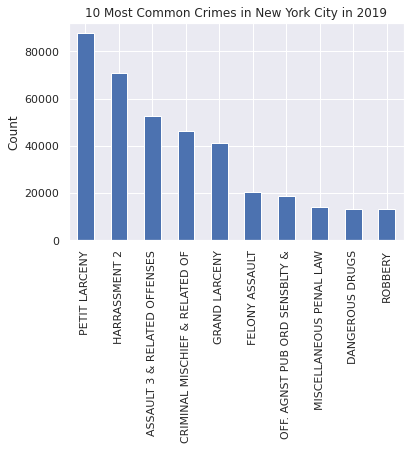

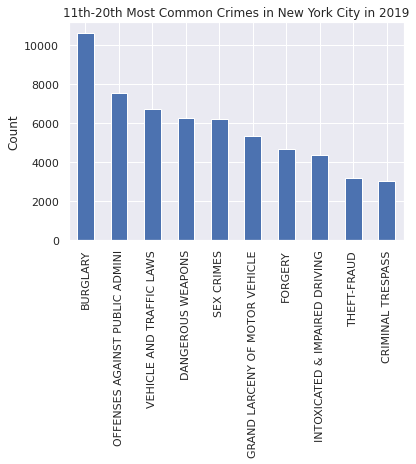

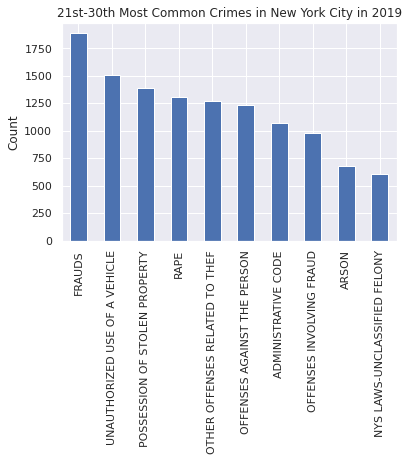

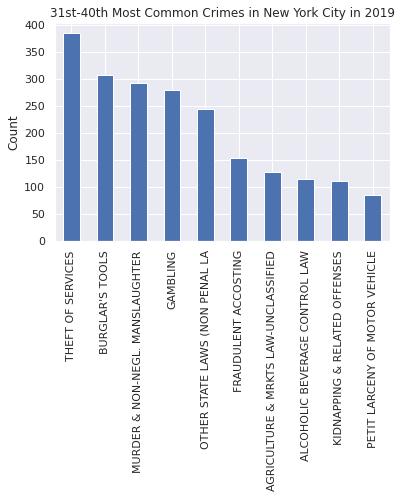

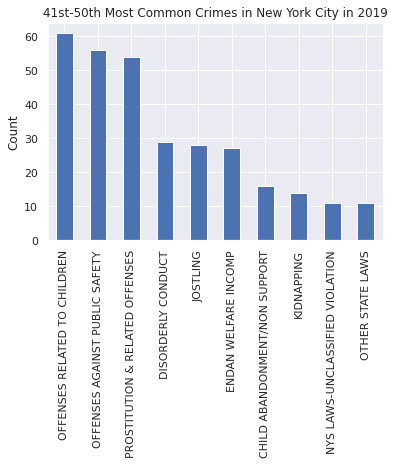

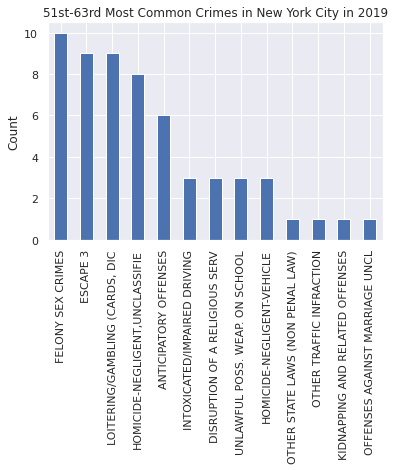

In [33]:
# Plotting Crime Type by Ranked Frequency in NYC for 2019

df2['OFNS_DESC'].value_counts()[:10].plot.bar()
plt.ylabel('Count')
plt.title('10 Most Common Crimes in New York City in 2019')
plt.show()

df2['OFNS_DESC'].value_counts()[10:20].plot.bar()
plt.ylabel('Count')
plt.title('11th-20th Most Common Crimes in New York City in 2019')
plt.show()

df2['OFNS_DESC'].value_counts()[20:30].plot.bar()
plt.ylabel('Count')
plt.title('21st-30th Most Common Crimes in New York City in 2019')
plt.show()

df2['OFNS_DESC'].value_counts()[30:40].plot.bar()
plt.ylabel('Count')
plt.title('31st-40th Most Common Crimes in New York City in 2019')
plt.show()

df2['OFNS_DESC'].value_counts()[40:50].plot.bar()
plt.ylabel('Count')
plt.title('41st-50th Most Common Crimes in New York City in 2019')
plt.show()

df2['OFNS_DESC'].value_counts()[50:].plot.bar()
plt.ylabel('Count')
plt.title('51st-63rd Most Common Crimes in New York City in 2019')
plt.show()

In [34]:
dfOffense.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,SEX CRIMES,MURDER & NON-NEGL. MANSLAUGHTER,ROBBERY,DANGEROUS DRUGS,Date_OCCRD3
Date_OCCRD2,,,,,,,,,,,,,,,,,,,,,,
18,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,0,0,1,0,2019-12-31 18:00:00
17,487138011,BRONX,12/29/2019,17:20:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/29/2019,40.830641,-73.874879,1,0,0,0,0,1,0,2019-12-29 17:20:00
12,227601821,MANHATTAN,12/29/2019,12:30:00,12/29/2019,13:30:00,COMPLETED,MISDEMEANOR,SEX CRIMES,"SEXUAL ABUSE 3,2",STREET,12/29/2019,40.764818,-73.985190,0,1,0,1,0,0,0,2019-12-29 12:30:00
14,260307851,MANHATTAN,12/23/2019,14:41:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,DELIVERY PERSON",STREET,12/23/2019,40.713476,-73.997303,1,0,0,0,0,1,0,2019-12-23 14:41:00
0,175176016,BRONX,12/22/2019,00:15:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/22/2019,40.886651,-73.859425,1,0,0,0,0,1,0,2019-12-22 00:15:00


In [35]:
# Change column names for offenses dataframe
dfOffense.columns
dfOffense.columns = ['CMPLT_NUM', 'BORO_NM', 'CMPLNT_FR_DT','CMPLNT_FR_TM', 'CMPLNT_TO_DT',
              'CMPLNT_TO_TM', 'CRM_STTUS', 'LAW_CODE', 'OFNS_DESC', 'PD_DESC', 
              'PREM_TYP_DESC', 'RPT_DT', 'LATITUDE', 'LONGITUDE', 'FELONY',
              'MISDEMEANOR', 'VIOLATION', 'SEX_CRIMES',
              'MURDER_NON_NEGLECTFUL_MANSLAUGHTER', 'ROBBERY', 'DANGEROUS_DRUGS', 'DATE_OCCRD3']

In [36]:
dfOffense.head()

,CMPLT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_STTUS,LAW_CODE,OFNS_DESC,PD_DESC,PREM_TYP_DESC,RPT_DT,LATITUDE,LONGITUDE,FELONY,MISDEMEANOR,VIOLATION,SEX_CRIMES,MURDER_NON_NEGLECTFUL_MANSLAUGHTER,ROBBERY,DANGEROUS_DRUGS,DATE_OCCRD3
Date_OCCRD2,,,,,,,,,,,,,,,,,,,,,,
18,314773184,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681,1,0,0,0,0,1,0,2019-12-31 18:00:00
17,487138011,BRONX,12/29/2019,17:20:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/29/2019,40.830641,-73.874879,1,0,0,0,0,1,0,2019-12-29 17:20:00
12,227601821,MANHATTAN,12/29/2019,12:30:00,12/29/2019,13:30:00,COMPLETED,MISDEMEANOR,SEX CRIMES,"SEXUAL ABUSE 3,2",STREET,12/29/2019,40.764818,-73.985190,0,1,0,1,0,0,0,2019-12-29 12:30:00
14,260307851,MANHATTAN,12/23/2019,14:41:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,DELIVERY PERSON",STREET,12/23/2019,40.713476,-73.997303,1,0,0,0,0,1,0,2019-12-23 14:41:00
0,175176016,BRONX,12/22/2019,00:15:00,NaN,NaN,COMPLETED,FELONY,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/22/2019,40.886651,-73.859425,1,0,0,0,0,1,0,2019-12-22 00:15:00


In [37]:
# Create data frame for sex crimes reported at midnight, which is the most frequent time period for such crimes

dfSexCrimes = dfOffense[dfOffense.index.isin([0])]
dfSexCrimes = dfSexCrimes[dfSexCrimes.SEX_CRIMES==1]
dfSexCrimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632 entries, 0 to 0
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   CMPLT_NUM                           632 non-null    int64         
 1   BORO_NM                             632 non-null    object        
 2   CMPLNT_FR_DT                        632 non-null    object        
 3   CMPLNT_FR_TM                        632 non-null    object        
 4   CMPLNT_TO_DT                        519 non-null    object        
 5   CMPLNT_TO_TM                        519 non-null    object        
 6   CRM_STTUS                           632 non-null    object        
 7   LAW_CODE                            632 non-null    object        
 8   OFNS_DESC                           632 non-null    object        
 9   PD_DESC                             632 non-null    object        
 10  PREM_TYP_DESC               

In [38]:
# Create data frame for murder and non-neglectful manslaughter crimes reported at night between 9 pm and 1 am. These are the times with the highest frequency for such crimes.

dfMurderCrimes = dfOffense[dfOffense.index.isin([21,22,23,0,1])]
dfMurderCrimes = dfMurderCrimes[dfMurderCrimes.MURDER_NON_NEGLECTFUL_MANSLAUGHTER==1]
dfMurderCrimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 1 to 22
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   CMPLT_NUM                           108 non-null    int64         
 1   BORO_NM                             0 non-null      object        
 2   CMPLNT_FR_DT                        108 non-null    object        
 3   CMPLNT_FR_TM                        108 non-null    object        
 4   CMPLNT_TO_DT                        0 non-null      object        
 5   CMPLNT_TO_TM                        0 non-null      object        
 6   CRM_STTUS                           108 non-null    object        
 7   LAW_CODE                            108 non-null    object        
 8   OFNS_DESC                           108 non-null    object        
 9   PD_DESC                             0 non-null      object        
 10  PREM_TYP_DESC              

In [39]:
# Create data frame for drug related crimes reported at 6 am. This is an outlier time for drugs to be reported as the surrounding times have very low frequency.

dfDrugsCrimes = dfOffense[dfOffense.index.isin([6])]
dfDrugsCrimes = dfDrugsCrimes[dfDrugsCrimes.DANGEROUS_DRUGS==1]
dfDrugsCrimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533 entries, 6 to 6
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   CMPLT_NUM                           533 non-null    int64         
 1   BORO_NM                             533 non-null    object        
 2   CMPLNT_FR_DT                        533 non-null    object        
 3   CMPLNT_FR_TM                        533 non-null    object        
 4   CMPLNT_TO_DT                        440 non-null    object        
 5   CMPLNT_TO_TM                        440 non-null    object        
 6   CRM_STTUS                           533 non-null    object        
 7   LAW_CODE                            533 non-null    object        
 8   OFNS_DESC                           533 non-null    object        
 9   PD_DESC                             533 non-null    object        
 10  PREM_TYP_DESC               

In [40]:
# Create dataframe for all marijuana related drug crimes

dfDrugsMarijuana = dfDrugs[dfDrugs.PD_DESC.str.contains('MARIJUANA')]
dfDrugsMarijuana.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1838 entries, 2019-12-13 20:00:00 to 2019-01-05 22:15:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CMPLT_NUM      1838 non-null   int64         
 1   BORO_NM        1838 non-null   object        
 2   CMPLNT_FR_DT   1838 non-null   object        
 3   CMPLNT_FR_TM   1838 non-null   object        
 4   CMPLNT_TO_DT   1506 non-null   object        
 5   CMPLNT_TO_TM   1506 non-null   object        
 6   CRM_STTUS      1838 non-null   object        
 7   LAW_CODE       1838 non-null   object        
 8   OFNS_DESC      1838 non-null   object        
 9   PD_DESC        1838 non-null   object        
 10  PREM_TYP_DESC  1837 non-null   object        
 11  RPT_DT         1838 non-null   object        
 12  LATITUDE       1838 non-null   float64       
 13  LONGITUDE      1838 non-null   float64       
 14  FELONY         1838 non-null   int64

In [41]:
# Create dataframe for all sale related drug crimes

dfDrugsSale = dfDrugs[dfDrugs.PD_DESC.str.contains('SALE')]
dfDrugsSale.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2333 entries, 2019-12-13 20:00:00 to 2019-01-03 14:20:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CMPLT_NUM      2333 non-null   int64         
 1   BORO_NM        2333 non-null   object        
 2   CMPLNT_FR_DT   2333 non-null   object        
 3   CMPLNT_FR_TM   2333 non-null   object        
 4   CMPLNT_TO_DT   1923 non-null   object        
 5   CMPLNT_TO_TM   1924 non-null   object        
 6   CRM_STTUS      2333 non-null   object        
 7   LAW_CODE       2333 non-null   object        
 8   OFNS_DESC      2333 non-null   object        
 9   PD_DESC        2333 non-null   object        
 10  PREM_TYP_DESC  2331 non-null   object        
 11  RPT_DT         2333 non-null   object        
 12  LATITUDE       2333 non-null   float64       
 13  LONGITUDE      2333 non-null   float64       
 14  FELONY         2333 non-null   int64

In [42]:
# Extract latitude and longitude data from dataframe and make it into array with tuples.

def extract_coords(dfname):
  X = np.array((dfname.LATITUDE.array,dfname.LONGITUDE.array)).T
  return X


In [119]:
# number of components in GMM model can be decided by using below code
# it produces the GMM for various cluster sizes based on components defined and then visualizes the AIC and BIC scores. Lowest scores are relfective of the best model.

def model_eval(X,n):
  n_components = np.arange(1, n)
  models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
            for n in n_components]
  
  plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
  plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
  plt.legend(loc='best')
  plt.xlabel('Number of Components')
  plt.ylabel('AIC/BIC')
  return models


In [123]:
# Draw an ellipse with a given position and covariance

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    return labels

In [124]:
# Get location data for the selected dataframes

X_SexCrimes = extract_coords(dfSexCrimes)
X_MurderCrimes = extract_coords(dfMurderCrimes)
X_DrugsCrimes = extract_coords(dfDrugsCrimes)
X_DrugsMarijuana = extract_coords(dfDrugsMarijuana)
X_DrugsSale = extract_coords(dfDrugsSale)

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (76) found smaller than n_clusters (77). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (76) found smaller than n_clusters (78). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (76) found smaller than n_clusters (79). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (76) found smaller than n_clusters (80). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/lib/python3.6/dist-packag

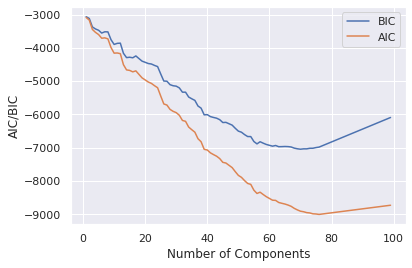

In [125]:
# Evaluate models for Sex Crimes

models_SexCrimes = model_eval(X_SexCrimes, 100)

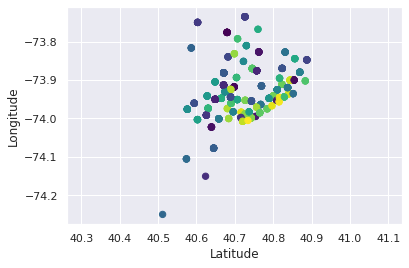

In [128]:
# For Sex Crimes, best n is 76, which corresponds to model index 75

labels_SexCrimes = plot_gmm(models_SexCrimes[75],X_SexCrimes)

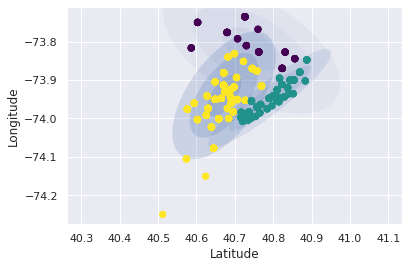

In [130]:
# Alternative sex crime clusters

labels_SexCrimes_alt = plot_gmm(models_SexCrimes[2],X_SexCrimes)

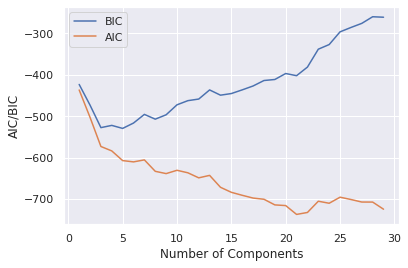

In [131]:
# Evaluate models for Murder and Non Neglectful Manslaughter Crimes

models_MurderCrimes = model_eval(X_MurderCrimes, 30) 

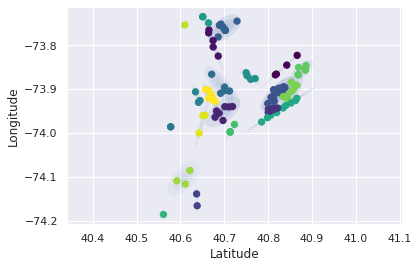

In [132]:
# AIC: For Murder and Non Neglectful Manslaughter Crimes, best n is 21, which corresponds to model index 20

labels_MurderCrimesAIC = plot_gmm(models_MurderCrimes[20],X_MurderCrimes) 

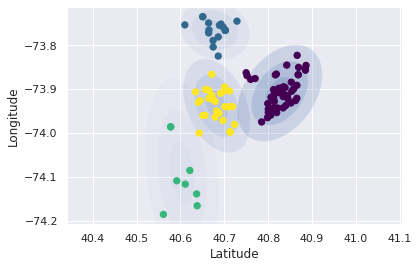

In [136]:
# BIC: For Murder and Non Neglectful Manslaughter Crimes, best n is 4, which corresponds to model index 3

labels_MurderCrimesBIC = plot_gmm(models_MurderCrimes[3],X_MurderCrimes) 

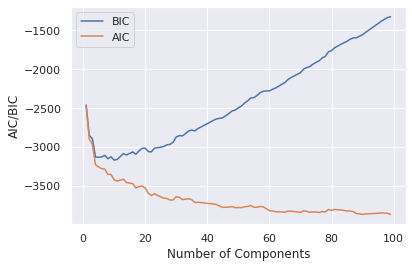

In [137]:
# Evaluate models for Drug related Crimes

models_DrugsCrimes = model_eval(X_DrugsCrimes, 100)

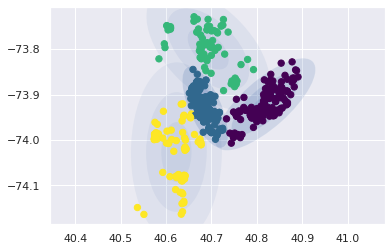

In [95]:
# AIC and BIC For Drugs related Crimes, best n is 4, which corresponds to model index 3. This is because of the steepest fall in AIC being observed for smaller n, even though AIC keeps decreasing later.

labels_DrugsCrimes = plot_gmm(models_DrugsCrimes[3],X_DrugsCrimes) #3

In [139]:
# BIC For Drugs related Crimes, best n is 4, which corresponds to model index 3

# labels_DrugsCrimes = plot_gmm(models_DrugsCrimes[3],X_DrugsCrimes) #3

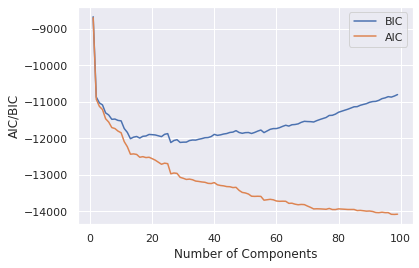

In [140]:
# Evaluate models for Marijuana related Crimes

models_DrugsMarijuana = model_eval(X_DrugsMarijuana, 100)

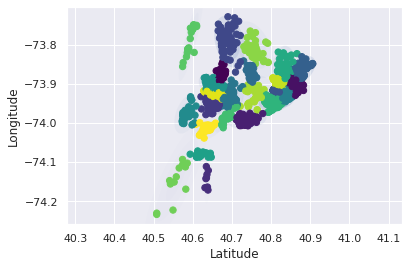

In [143]:
# For Marijuana related Crimes, best n is 24, which corresponds to model index 23

labels_DrugsMarijuana = plot_gmm(models_DrugsMarijuana[23],X_DrugsMarijuana)

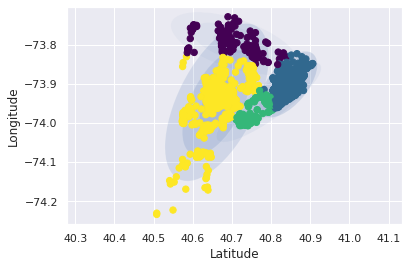

In [151]:
# Lower n alternative: For Marijuana related Crimes, alternative best n is 4, which corresponds to model index 3. This marks the steepest fall in AIC/BIC both 

labels_DrugsMarijuana_Alt = plot_gmm(models_DrugsMarijuana[3],X_DrugsMarijuana)

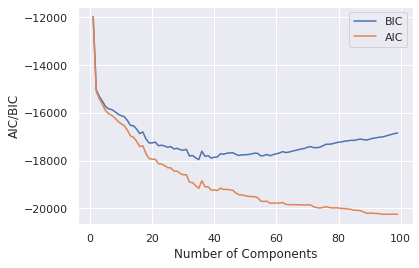

In [152]:
# Evaluate models for Drug Sale related Crimes

models_DrugsSale = model_eval(X_DrugsSale, 100)

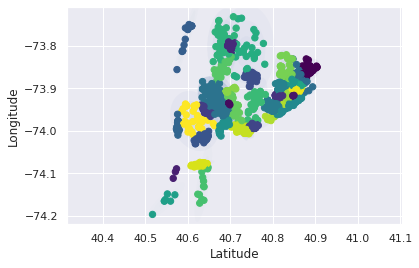

In [155]:
# For Marijuana related Crimes, best n is 35, which corresponds to model index 34

labels_DrugsSale = plot_gmm(models_DrugsSale[34],X_DrugsSale)

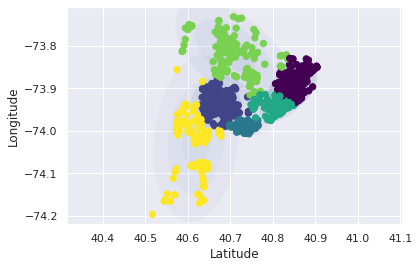

In [156]:
# Alternative for low clusters. For Marijuana related Crimes, alternative best n is 6, which corresponds to model index 5

labels_DrugsSale_Alt = plot_gmm(models_DrugsSale[5],X_DrugsSale)

In [160]:
# Export sex crime predictions for high n

dfSexCrimes_GMMPred1 = pd.DataFrame()
dfSexCrimes_GMMPred1['LATITUDE']=pd.Series(X_SexCrimes[:,0])
dfSexCrimes_GMMPred1['LONGITUDE']=pd.Series(X_SexCrimes[:,1])
dfSexCrimes_GMMPred1['CLUSTER_PREDICTION']=pd.Series(labels_SexCrimes)

dfSexCrimes_GMMPred1.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfSexCrimes_GMMPred1.csv")

In [164]:
# Export sex crime predictions for low n (alt)

dfSexCrimes_GMMPred2 = pd.DataFrame()
dfSexCrimes_GMMPred2['LATITUDE']=pd.Series(X_SexCrimes[:,0])
dfSexCrimes_GMMPred2['LONGITUDE']=pd.Series(X_SexCrimes[:,1])
dfSexCrimes_GMMPred2['CLUSTER_PREDICTION']=pd.Series(labels_SexCrimes_alt)

dfSexCrimes_GMMPred2.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfSexCrimes_GMMPred2.csv")

In [165]:
# Export murder crime predictions for AIC

dfMurderCrimes_GMMPredAIC = pd.DataFrame()
dfMurderCrimes_GMMPredAIC['LATITUDE']=pd.Series(X_MurderCrimes[:,0])
dfMurderCrimes_GMMPredAIC['LONGITUDE']=pd.Series(X_MurderCrimes[:,1])
dfMurderCrimes_GMMPredAIC['CLUSTER_PREDICTION']=pd.Series(labels_MurderCrimesAIC)

dfMurderCrimes_GMMPredAIC.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfMurderCrimes_GMMPredAIC.csv")

In [166]:
# Export murder crime predictions for BIC

dfMurderCrimes_GMMPredBIC = pd.DataFrame()
dfMurderCrimes_GMMPredBIC['LATITUDE']=pd.Series(X_MurderCrimes[:,0])
dfMurderCrimes_GMMPredBIC['LONGITUDE']=pd.Series(X_MurderCrimes[:,1])
dfMurderCrimes_GMMPredBIC['CLUSTER_PREDICTION']=pd.Series(labels_MurderCrimesBIC)

dfMurderCrimes_GMMPredBIC.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfMurderCrimes_GMMPredBIC.csv")

In [167]:
# Export drugs crime predictions

dfDrugsCrimes_GMMPred = pd.DataFrame()
dfDrugsCrimes_GMMPred['LATITUDE']=pd.Series(X_DrugsCrimes[:,0])
dfDrugsCrimes_GMMPred['LONGITUDE']=pd.Series(X_DrugsCrimes[:,1])
dfDrugsCrimes_GMMPred['CLUSTER_PREDICTION']=pd.Series(labels_DrugsCrimes)

dfDrugsCrimes_GMMPred.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfDrugsCrimes_GMMPred.csv")

In [168]:
# Export marijuana drug crime predictions for high n

dfMarijuanaCrimes_GMMPred1 = pd.DataFrame()
dfMarijuanaCrimes_GMMPred1['LATITUDE']=pd.Series(X_DrugsMarijuana[:,0])
dfMarijuanaCrimes_GMMPred1['LONGITUDE']=pd.Series(X_DrugsMarijuana[:,1])
dfMarijuanaCrimes_GMMPred1['CLUSTER_PREDICTION']=pd.Series(labels_DrugsMarijuana)

dfMarijuanaCrimes_GMMPred1.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfMarijuanaCrimes_GMMPred1.csv")

In [169]:
# Export marijuana drug crime predictions for low n (alt)

dfMarijuanaCrimes_GMMPred2 = pd.DataFrame()
dfMarijuanaCrimes_GMMPred2['LATITUDE']=pd.Series(X_DrugsMarijuana[:,0])
dfMarijuanaCrimes_GMMPred2['LONGITUDE']=pd.Series(X_DrugsMarijuana[:,1])
dfMarijuanaCrimes_GMMPred2['CLUSTER_PREDICTION']=pd.Series(labels_DrugsMarijuana_Alt)

dfMarijuanaCrimes_GMMPred2.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfMarijuanaCrimes_GMMPred2.csv")

In [170]:
# Export drug sale crime predictions for high n

dfDrugSaleCrimes_GMMPred1 = pd.DataFrame()
dfDrugSaleCrimes_GMMPred1['LATITUDE']=pd.Series(X_DrugsSale[:,0])
dfDrugSaleCrimes_GMMPred1['LONGITUDE']=pd.Series(X_DrugsSale[:,1])
dfDrugSaleCrimes_GMMPred1['CLUSTER_PREDICTION']=pd.Series(labels_DrugsSale)

dfDrugSaleCrimes_GMMPred1.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfDrugSaleCrimes_GMMPred1.csv")

In [171]:
# Export drug sale crime predictions for low n (alt)

dfDrugSaleCrimes_GMMPred2 = pd.DataFrame()
dfDrugSaleCrimes_GMMPred2['LATITUDE']=pd.Series(X_DrugsSale[:,0])
dfDrugSaleCrimes_GMMPred2['LONGITUDE']=pd.Series(X_DrugsSale[:,1])
dfDrugSaleCrimes_GMMPred2['CLUSTER_PREDICTION']=pd.Series(labels_DrugsSale_Alt)

dfDrugSaleCrimes_GMMPred2.to_csv("/content/gdrive/My Drive/AIT 690 Project/Data/dfDrugSaleCrimes_GMMPred2.csv")